In [1]:
import sys
import os
sys.path.append(f'{os.path.dirname(os.getcwd())}/utils')
from data_util import (download_data_local_check, prep_stock_data, prep_fx_data, calc_sharpe,
                       calc_romad, create_dataset, deep_learning_dataset, display_stop_target,
                       create_candlestick_corpus)
from candlestick_embeddings_util import create_candlestick_corpus

In [2]:
#from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import pickle
import random
import shutil
import time
import copy
import gc

%matplotlib inline

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import (mean_squared_error, accuracy_score)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy import interpolate

In [4]:
# def global_set_seed(seed_value):
#     os.environ['PYTHONHASHSEED']=str(seed_value)
#     random.seed(seed_value)
#     np.random.seed(seed_value)
#     tf.random.set_seed(seed_value)
# global_set_seed(0)
#np.random.seed = 1

In [5]:
data_source = 'fx' # 'fx', 'stock'

if data_source == 'fx':
    ### FX data #######
    fx_files = [
                 'EURUSD_1h_2003-2020.csv',
                 'GBPUSD_1h_2003-2020.csv',
                 'USDJPY_1h_2003-2020.csv',
                 'NZDUSD_1h_2003-2020.csv',
                 'AUDUSD_1h_2003-2020.csv',
                 'USDCAD_1h_2003-2020.csv',
                 'USDCHF_1h_2003-2020.csv',
                 ]

    loaded_files = prep_fx_data(fx_files)
        
if data_source == 'stock':
    ### stock data ######
    start = '2000-01-01'
    end = '2020-11-1'
    ## download data
    all_stock_data = download_data_local_check('SP500', start, end)
    loaded_files = prep_stock_data(all_stock_data, filter_start_date_tuple=None) #(2015,1,1)

EURUSD_1h_2003-2020.csv
GBPUSD_1h_2003-2020.csv
USDJPY_1h_2003-2020.csv
NZDUSD_1h_2003-2020.csv
AUDUSD_1h_2003-2020.csv
USDCAD_1h_2003-2020.csv
USDCHF_1h_2003-2020.csv


In [6]:
def save_numpy_to_csv_all_files(base_path, var):
    (x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw, test_data_raw,
     all_data) = deep_learning_dataset(var, train_validation=var.train_validation) 
    pd.concat([x,y], axis=1).to_csv(f'{base_path}/all_data_train.csv', mode='w', header=True,
                                    index=False)
    pd.concat([x_test, y_test], axis=1).to_csv(f'{base_path}/all_data_test.csv', mode='w',
                                               header=True, index=False)
    gc.collect()

def write_csv_to_tfrecords(file_name_no_extension):
    ### Read csv into pandas and save to tfrecords
        csv = pd.read_csv(f'{file_name_no_extension}.csv').values
        with tf.io.TFRecordWriter(f'{file_name_no_extension}.tfrecords') as writer:
            for row in csv:
                features, label = row[:-1], row[-1]
                example = tf.train.Example()
                example.features.feature["features"].float_list.value.extend(features)
                example.features.feature["label"].float_list.value.append(label)
                writer.write(example.SerializeToString())
        
def parse_tfrecord(serialized_example, var):
    input_vector_size = var.vector_size if var.embeddings else len(var.cols)
    feature_description = {
        'features': tf.io.FixedLenFeature(shape=(var.input_len, input_vector_size),
                                          dtype=tf.float32),
        'label': tf.io.FixedLenFeature(shape=(1), dtype=tf.float32),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    #example['features'] = tf.reshape(example['features'], shape=(var.input_len, len(var.cols)))
    
    return example['features'], example['label']

def create_tfrecord_dataset(file_name_no_extension, var):
    ### Write csv to tfrecords
    write_csv_to_tfrecords(file_name_no_extension)
    ### Read in single file
    dataset = tf.data.TFRecordDataset(filenames = [f'{file_name_no_extension}.tfrecords'])
#     for row in dataset.take(1):
#         print(parse_tfrecord(row, var))
    ### Parse files
    dataset = dataset.map(lambda x: parse_tfrecord(x, var), num_parallel_calls=4)
    # remove old cache files
    file_start = os.path.split(file_name_no_extension)[-1]
    dir_path = os.path.dirname(file_name_no_extension)
    for file in os.listdir(dir_path):
        if f'{file_start}_cache' in file:
            os.remove(f'{dir_path}/{file}')
    ### Cache parsed file onto disk
    dataset = dataset.cache(filename=f'{file_name_no_extension}_cache')
    print('caching:',f'{file_name_no_extension}_cache')
    dataset = dataset.batch(batch_size=var.batch_size).prefetch( 
        buffer_size=tf.data.experimental.AUTOTUNE) #.shuffle(buffer_size=1024, seed=1)
    return dataset

In [7]:
def dnn_model(l1_reg, l2_reg, drop_rate, input_len, output_layer, layer_kwargs, var):
    input_vector_size = var.vector_size if var.embeddings else len(var.cols)
    model = tf.keras.Sequential([
        layers.Reshape((input_len * input_vector_size,), input_shape=[input_len, input_vector_size]),
        layers.Dense(units=1000, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        layers.Dense(units=1000, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        layers.Dense(units=1000, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=500, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        output_layer,
    ])
    return model

def dnn_model_sweep(l1_reg, l2_reg, drop_rate, input_len, output_layer, layer_kwargs, var):
    input_vector_size = var.vector_size if var.embeddings else len(var.cols)
    first = layers.Reshape((input_len * input_vector_size,), input_shape=[input_len, input_vector_size])
    hidden_layers = []
    for _ in range(var.layers):
        hidden_layers.append(layers.Dropout(drop_rate))
        hidden_layers.append(layers.Dense(units=var.units, activation='relu',
                                          kernel_regularizer=l1_l2(l1_reg, l2_reg), **layer_kwargs))
    model = tf.keras.Sequential([first] + hidden_layers + [output_layer])
    return model

def conv1d_model(l1_reg, l2_reg, drop_rate, input_len, output_layer, layer_kwargs, var):
    model = tf.keras.Sequential([
        layers.Conv1D(filters=10, kernel_size=4, input_shape=[input_len, len(var.cols)],
                      **layer_kwargs),        
        layers.Flatten(),
        layers.Dense(units=10, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        output_layer,
    ])
    return model

def inception1d_model(l1_reg, l2_reg, drop_rate, input_len, output_layer, layer_kwargs, var):
    input_img = layers.Input(shape=(input_len, 1))

    layer_1 = layers.Conv1D(10, 1, padding='same', activation='relu', **layer_kwargs)(input_img)
    layer_1 = layers.Conv1D(10, 5, padding='same', activation='relu', **layer_kwargs)(layer_1)

    layer_2 = layers.Conv1D(10, 1, padding='same', activation='relu', **layer_kwargs)(input_img)
    layer_2 = layers.Conv1D(10, 10, padding='same', activation='relu', **layer_kwargs)(layer_2)

    layer_3 = layers.MaxPooling1D(3, strides=1, padding='same')(input_img)
    layer_3 = layers.Conv1D(10, 1, padding='same', activation='relu', **layer_kwargs)(layer_3)

    mid_1 = layers.concatenate([layer_1, layer_2, layer_3], axis = 2)
    flat_1 = layers.Flatten()(mid_1)

    dense_1 = layers.Dense(128, activation='relu', **layer_kwargs)(flat_1)
    dense_2 = layers.Dense(64, activation='relu', **layer_kwargs)(dense_1)
    dense_3 = layers.Dense(32, activation='relu', **layer_kwargs)(dense_2)
    output = output_layer(dense_3)
    model = tf.keras.models.Model([input_img], output)
    return model

def lstm_model(l1_reg, l2_reg, drop_rate, input_len, output_layer, layer_kwargs, var):
    input_vector_size = var.vector_size if var.embeddings else len(var.cols)
    model = tf.keras.Sequential([
        layers.LSTM(units=10, return_sequences=True, input_shape=[None, input_vector_size],
                    **layer_kwargs),   
        layers.LSTM(units=10, return_sequences=False, **layer_kwargs), 
        layers.Dense(units=10, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=10, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        layers.Dropout(drop_rate),
        layers.Dense(units=10, activation='relu', kernel_regularizer=l1_l2(l1_reg, l2_reg),
                     **layer_kwargs),
        output_layer,
    ])
    return model

def lstm_model_sweep(l1_reg, l2_reg, drop_rate, input_len, output_layer, layer_kwargs, var):
    input_vector_size = var.vector_size if var.embeddings else len(var.cols)
    first_return = False
    lstm_layers = []
    for _ in range(var.lstm_layers - 1):
        lstm_layers.append(layers.LSTM(units=var.units, return_sequences=first_return, **layer_kwargs)) 
        first_return = True
              
    first = layers.LSTM(units=var.units, return_sequences=first_return, input_shape=[None, input_vector_size],
                        **layer_kwargs) 
    hidden_layers = []
    for _ in range(var.layers):
        hidden_layers.append(layers.Dropout(drop_rate))
        hidden_layers.append(layers.Dense(units=var.units, activation='relu',
                                          kernel_regularizer=l1_l2(l1_reg, l2_reg), **layer_kwargs)) 
    model = tf.keras.Sequential([first] + lstm_layers[::-1] + hidden_layers + [output_layer])
    return model

In [43]:
class algo_variables():
    pass

var = algo_variables()
var.window = 30 # number of training bars
var.pca_features = False # False, 10  #must be smaller than window
var.standardize = 'min_max' #'std', 'min_max' False
var.norm_by_vol = False #True
var.data_percentage_diff = 'close_diff' # False, 'close_diff', 'ohlc_diff', 'open_diff'
var.data_percentage_diff_y = True
var.train_split = datetime(2019,1,1) #0.9, datetime(2018,1,1)
var.resample = '1D' # None '1D', '4H', '1W'
var.read_single_file = None #all_files[3] #None
var.loaded_files = loaded_files

var.num_bars = 100 # prediction horizon
var.problem_type = 'binary' #'regression' 'binary' 'category'
if var.problem_type == 'category':
    var.std_thresh = 0.5 # to determine a positive, negative or flat trade
var.dataset_type = 'stock' #'wave', 'random', 'stock', 'monte_carlo'
var.close_only = False
if var.close_only:
    var.cols = ['Close'] if var.dataset_type in ['stock','monte_carlo'] else ['univariate']
else:
    var.cols = ['Open', 'High', 'Low', 'Close'] if var.dataset_type == 'stock' else ['univariate']
var.multi_y = False

###
var.input_len = var.pca_features if var.pca_features else var.window
###

## target/stop binary outcomes (1 R/R) ##
var.target_stop = False 
if var.target_stop:
    var.num_bars = 1 # must be equal to 1!
    var.problem_type = 'binary'
    var.dataset_type = 'stock'
    var.close_only = False
    var.cols = ['Open', 'High', 'Low', 'Close']
    var.bar_horizon = 10000 # how long to wait for stop or target hit, otherwise assign current profit
    var.bar_size_ma = 100 # how long is moving average for bar size (used to calc stop and target)
    var.stop_target_size = 4 # size of stop and target relative to averge bar size


var.embeddings = False
var.embedding_type = None #None 'light'
if var.embeddings:
    var.standardize = False 
    var.pca_features = False
    var.vector_size = 200 # 200, 4
    if var.embedding_type == 'light':
        var.vector_size = 1
    
generator = True
if generator: 
    ## save all stocks to csv and tfrecords, then load tfrecords as dataset
    var.train_validation = 0.8 #False # Uses traning data to create test set (for validation)
    var.batch_size = 500
    base_path = f'C:/Users/Jameshuckle/Documents/Algo_Trading/data'
    save_numpy_to_csv_all_files(base_path, var)
    train_dataset = create_tfrecord_dataset(f'{base_path}/all_data_train', var)
    test_dataset = create_tfrecord_dataset(f'{base_path}/all_data_test', var)
else:
    ### load single stock into numpy
    (x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw,
     test_data_raw) = create_dataset(file_name=list(loaded_files.keys())[0], var=var)
    train_dataset, test_dataset = [], []
    

In [9]:
# display_stop_target(test_data_raw, y_test, y_test_pct_diff, var, start=0,
#                     end=550, vline=500,hline=1.1)

In [11]:
def get_model_arch(model_arch, var, sweep=False):
    seed_value = 1
    layer_kwargs = {'kernel_initializer':initializers.glorot_uniform(seed=seed_value),
                    'bias_initializer':initializers.Constant(0.1),
                   }

    if var.problem_type == 'binary': 
        output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid', **layer_kwargs)
    elif var.problem_type == 'category': 
        output_layer = tf.keras.layers.Dense(units=3, activation='softmax', **layer_kwargs)
    else: 
        output_layer = tf.keras.layers.Dense(units=1, activation=None, **layer_kwargs)

    if model_arch == 'dnn': 
        arch = dnn_model
        if sweep: 
            arch = dnn_model_sweep
    elif model_arch == 'conv1d': 
        arch = conv1d_model
    elif model_arch == 'incept1d': 
        arch = inception1d_model
    elif model_arch == 'lstm': 
        arch = lstm_model
        if sweep: 
            arch = lstm_model_sweep

    model = arch(var.l1_reg, var.l2_reg, var.drop_rate, var.input_len, output_layer,
                       layer_kwargs, var)
    return model

def reset_model_checkpoint(path=os.getcwd()):
    total_epochs = 0
    all_history = {}
    # delete last saved model
    checkpoint_path_base = f'{path}/model_checkpoints'
    checkpoint_path_model = checkpoint_path_base + '/model.ckpt'
    if os.path.exists(checkpoint_path_base):
        shutil.rmtree(checkpoint_path_base)
    return total_epochs, all_history, checkpoint_path_base, checkpoint_path_model

def compile_model(model, lr, var):
    adam = tf.keras.optimizers.Adam(learning_rate=lr)

    if var.problem_type == 'binary': 
        model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    elif var.problem_type == 'category':
        model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    else:
        rmse = tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error', dtype=None)
        model.compile(optimizer=adam, loss='mse', metrics=[rmse])
        
    return model

def set_model_hyperparams(epochs, kwargs, plot_lr_rate, decrease_lr_rate, validation,
                          test_dataset, generator):
        
    if plot_lr_rate:
        kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-8 * 10**(epoch / (epochs / 7))))

    elif decrease_lr_rate:
        kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-3 / 10**(epoch / epochs))) #1e-2
        #kwargs['callbacks'].append(tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3))

    if validation:   
        if generator:
            kwargs['validation_data'] = test_dataset
        else:
            kwargs['validation_split'] = 0.7
            
    return kwargs


def del_unneeded_checkpoints(checkpoint_path_base, all_history, metric):
    print('deleting uneeded checkpoints')
    epochs_idx = [
        np.argmin(all_history['val_loss']) + 1,
        np.argmax(all_history['val_loss']) + 1,
        np.argmin(all_history[f'val_{metric}']) + 1, 
        np.argmax(all_history[f'val_{metric}']) + 1,
        len(all_history['val_loss']),
    ]
    for cp_file in os.listdir(checkpoint_path_base):
        if 'model_epoch-' in cp_file:
            epoch = int(cp_file.split('-')[1].split('.')[0])
            if epoch not in epochs_idx:
                os.remove(f'{checkpoint_path_base}/{cp_file}')

In [12]:
tf.keras.backend.clear_session()
###
model_arch = 'dnn' # 'dnn','lstm','conv1d','incept1d'
var.l1_reg = 1e-7 #1e-6
var.l2_reg = 0 #1e-7 #1e-5
var.drop_rate = 0 #0.1 #0.2
###
sweep = True
if sweep:
    var.layers = 5
    var.units = 200
    var.lstm_layers = 1

model = get_model_arch(model_arch, var, sweep)
(total_epochs, all_history, checkpoint_path_base,
 checkpoint_path_model) = reset_model_checkpoint(
    path='B:Algo_Trading/model_checkpoints')

## Train model

In [13]:
# load model to keep continuity of epochs. To create new model run cell above.
if os.path.exists(checkpoint_path_model):
    print('loading model')
    model = tf.keras.models.load_model(checkpoint_path_model)

model = compile_model(model=model, lr=1e-5, var=var)

gc.collect()

plot_lr_rate = False
decrease_lr_rate = False
validation = True
epochs = 200

checkpoint_path_cb = checkpoint_path_base+'/model_epoch-{epoch}.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_cb,
                                                 save_best_only=False,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max', verbose=0)
kwargs = {'verbose':2, 'epochs':epochs, 'initial_epoch':total_epochs, 'shuffle':False,
          'callbacks':[cp_callback]}
kwargs = set_model_hyperparams(epochs, kwargs, plot_lr_rate, decrease_lr_rate,
                               validation, test_dataset, generator)

if generator:
    ### Parellelize loading
    history = model.fit(x=train_dataset, **kwargs)
else:
    batch_size = 100
    history = model.fit(x, y, batch_size=batch_size, **kwargs)
                        
model.save(checkpoint_path_model)
print('\n---------------')
total_epochs = epochs
print('\ntotal_epochs',total_epochs)
gc.collect()

for key, value in history.history.items():
    all_history.setdefault(key, [])
    all_history[key] += value
    

Epoch 1/200
3185/3185 - 53s - loss: 0.6257 - accuracy: 0.6664 - val_loss: 0.6670 - val_accuracy: 0.6245
Epoch 2/200
3185/3185 - 16s - loss: 0.6286 - accuracy: 0.6656 - val_loss: 0.6656 - val_accuracy: 0.6245
Epoch 3/200
3185/3185 - 16s - loss: 0.6309 - accuracy: 0.6629 - val_loss: 0.6645 - val_accuracy: 0.6245
Epoch 4/200
3185/3185 - 15s - loss: 0.6303 - accuracy: 0.6632 - val_loss: 0.6646 - val_accuracy: 0.6245
Epoch 5/200
3185/3185 - 15s - loss: 0.6291 - accuracy: 0.6650 - val_loss: 0.6648 - val_accuracy: 0.6245
Epoch 6/200
3185/3185 - 16s - loss: 0.6282 - accuracy: 0.6659 - val_loss: 0.6651 - val_accuracy: 0.6245
Epoch 7/200
3185/3185 - 15s - loss: 0.6285 - accuracy: 0.6655 - val_loss: 0.6652 - val_accuracy: 0.6245
Epoch 8/200
3185/3185 - 16s - loss: 0.6282 - accuracy: 0.6655 - val_loss: 0.6656 - val_accuracy: 0.6245
Epoch 9/200
3185/3185 - 17s - loss: 0.6273 - accuracy: 0.6663 - val_loss: 0.6658 - val_accuracy: 0.6245
Epoch 10/200
3185/3185 - 15s - loss: 0.6271 - accuracy: 0.6665 -

Epoch 157/200
3185/3185 - 18s - loss: 0.5808 - accuracy: 0.6989 - val_loss: 0.6941 - val_accuracy: 0.5483
Epoch 158/200
3185/3185 - 18s - loss: 0.5806 - accuracy: 0.6991 - val_loss: 0.6944 - val_accuracy: 0.5476
Epoch 159/200
3185/3185 - 17s - loss: 0.5804 - accuracy: 0.6992 - val_loss: 0.6948 - val_accuracy: 0.5465
Epoch 160/200
3185/3185 - 17s - loss: 0.5803 - accuracy: 0.6993 - val_loss: 0.6952 - val_accuracy: 0.5454
Epoch 161/200
3185/3185 - 18s - loss: 0.5801 - accuracy: 0.6994 - val_loss: 0.6957 - val_accuracy: 0.5440
Epoch 162/200
3185/3185 - 16s - loss: 0.5799 - accuracy: 0.6995 - val_loss: 0.6963 - val_accuracy: 0.5425
Epoch 163/200
3185/3185 - 17s - loss: 0.5797 - accuracy: 0.6996 - val_loss: 0.6967 - val_accuracy: 0.5417
Epoch 164/200
3185/3185 - 16s - loss: 0.5795 - accuracy: 0.6997 - val_loss: 0.6972 - val_accuracy: 0.5406
Epoch 165/200
3185/3185 - 17s - loss: 0.5793 - accuracy: 0.6999 - val_loss: 0.6976 - val_accuracy: 0.5395
Epoch 166/200
3185/3185 - 17s - loss: 0.5792 -

NameError: name 'metric' is not defined

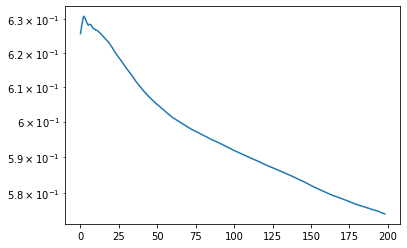

In [14]:
start_epoch = 0
end_epoch = -1

if plot_lr_rate:
    plt.plot(all_history['lr'][start_epoch:end_epoch],
             all_history['loss'][start_epoch:end_epoch])
    plt.xscale('log')
    lowest_loss_idx = np.argmin(all_history['loss'])
    print('best lr:',all_history['lr'][lowest_loss_idx])
elif decrease_lr_rate:
    plt.plot(all_history['lr'][start_epoch:end_epoch],
             all_history['loss'][start_epoch:end_epoch])
    plt.title('learning rate')
    plt.xscale('log')
    plt.xlim(max(all_history['lr'][start_epoch:end_epoch]),
             min(all_history['lr'][start_epoch:end_epoch]))
else:
    plt.plot(all_history['loss'][start_epoch:end_epoch])
    plt.yscale('log')

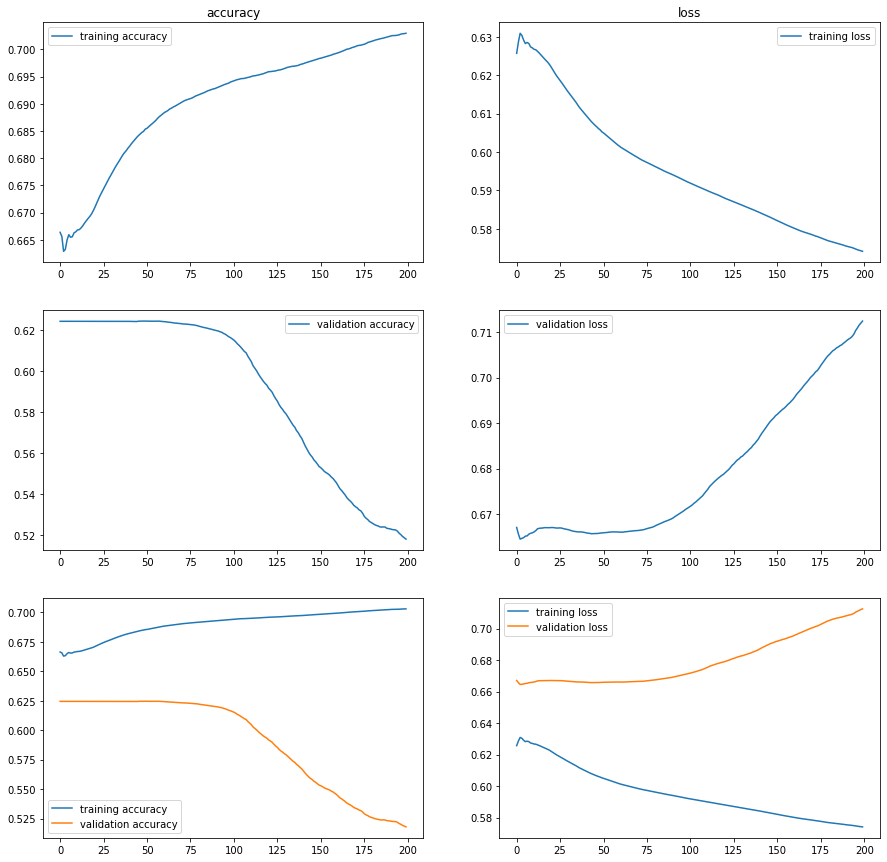

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

metric = 'root_mean_squared_error' if var.problem_type == 'regression' else 'accuracy'
epoch_show_from = int(epochs * 0)
# metric
ax[0][0].plot(all_history[metric][epoch_show_from:])
ax[0][0].legend([f'training {metric}'])
ax[0][0].set_title(metric)
# loss
ax[0][1].plot(all_history['loss'][epoch_show_from:])
ax[0][1].legend([f'training loss'])
ax[0][1].set_title('loss')

if validation:
    # metric
    ax[1][0].plot(all_history[f'val_{metric}'][epoch_show_from:])
    ax[1][0].legend([f'validation {metric}'])
    ax[2][0].plot(all_history[metric][epoch_show_from:])
    ax[2][0].plot(all_history[f'val_{metric}'][epoch_show_from:])
    ax[2][0].legend([f'training {metric}',f'validation {metric}'])

    # loss
    ax[1][1].plot(all_history[f'val_loss'][epoch_show_from:])
    ax[1][1].legend([f'validation loss'])
    ax[2][1].plot(all_history['loss'][epoch_show_from:])
    ax[2][1].plot(all_history[f'val_loss'][epoch_show_from:])
    ax[2][1].legend([f'training loss',f'validation loss'])
else:
    ax[2][0].legend(['train'])
    ax[2][1].legend(['train'])

In [16]:
del_unneeded_checkpoints(checkpoint_path_base, all_history, metric)

deleting uneeded checkpoints


In [17]:
def explore_epoch(metric, man_epoch_idx, man_val_metric, checkpoint_path_base, all_history, model):
    if man_epoch_idx:
        print('load weights from epoch', man_epoch_idx)
        checkpoint_path = f'{checkpoint_path_base}/model_epoch-{man_epoch_idx}.ckpt'
    else:
        val_metric = f'val_{metric}' if not man_val_metric else man_val_metric
        print(f'Loaded weights from best {val_metric}')
        if val_metric in ['val_root_mean_squared_error', 'val_loss']:
            best_idx = np.argmin(all_history[val_metric])
            best_acc = round((all_history[val_metric][best_idx]), 4)
        else:
            best_idx = np.argmax(all_history[val_metric])
            best_acc = round((all_history[val_metric][best_idx]), 4)
        print(f'best {val_metric}: {best_acc} | epoch={best_idx}')
        checkpoint_path = f'{checkpoint_path_base}/model_epoch-{best_idx + 1}.ckpt'
    model.load_weights(checkpoint_path)
    return model

In [18]:
man_epoch_idx = 0 #Set to 0 or False to choose best accuracy, otherwise choose epoch to load
man_val_metric = False #False 'val_loss'

model = explore_epoch(metric, man_epoch_idx, man_val_metric, checkpoint_path_base, all_history, model)

Loaded weights from best val_accuracy
best val_accuracy: 0.6246 | epoch=47


In [19]:
#raise Exception('stop at this cell')

In [20]:
def create_review_data_set(review_set, var):
    if review_set == 'train':
        review_x_data = var.x 
        review_y_data = var.y
        review_y_pct_diff = var.y_pct_diff
    elif review_set == 'test':
        review_x_data = var.x_test
        review_y_data = var.y_test
        review_y_pct_diff = var.y_test_pct_diff
    elif review_set == 'all':
        review_x_data = np.concatenate([var.x, var.x_test], axis=0)
        review_y_data = np.concatenate([var.y, var.y_test], axis=0)
        review_y_pct_diff = np.concatenate([var.y_pct_diff, var.y_test_pct_diff], axis=0)
    return review_x_data, review_y_data, review_y_pct_diff

def format_predictions_tanh(review_x_data, model, var):
    raw_predictions = model.predict(review_x_data)
    if var.problem_type == 'binary': 
        predictions_tanh = np.where(raw_predictions.flatten() < 0.5, -1, 1) 
    elif var.problem_type == 'category':
        class_idx = np.argmax(raw_predictions, axis=1)
        predictions_tanh = class_idx - 1
        raw_predictions[:, 0] = -raw_predictions[:, 0] 
        raw_predictions[:, 1] = 0
        raw_predictions = raw_predictions[range(raw_predictions.shape[0]),class_idx]
    else:
        predictions_tanh = raw_predictions.flatten()
    return raw_predictions, predictions_tanh

def cut_off_start_review_data_for_prediction(review_x_data, review_set, var):
    # cut off start of raw data until first prediction candle
    if review_set in 'train':
        review_data_raw = var.train_data_raw[-len(review_x_data):]
    elif review_set == 'test':
        review_data_raw = var.test_data_raw[-len(review_x_data):]
    elif review_set == 'all':
        review_data_raw = np.concatenate([var.train_data_raw[:-len(review_x_data)],
                                          var.test_data_raw[:-len(review_x_data)]], axis=0)
    review_data_raw = review_data_raw[:,-1]   
    
    return review_data_raw

def see_predictions(review_set, model, var): 
    review_x_data, review_y_data, review_y_pct_diff = create_review_data_set(review_set, var)
    raw_predictions, predictions_tanh = format_predictions_tanh(review_x_data, model, var)
    review_data_raw = cut_off_start_review_data_for_prediction(review_x_data, review_set, var)
    return (review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions,
           predictions_tanh)

def plot_preds(bars_to_plot, predictions_tanh, review_data_raw):
    fig, ax1 = plt.subplots()
    ax1.plot(predictions_tanh[:bars_to_plot], c='orange')
    ax1.legend(['prediction'])
    ax2 = ax1.twinx()
    ax2.plot(review_data_raw[:bars_to_plot], c='blue')
    #ax2.plot(review_ data_raw[var.input_len + var.num_bars: var.input_len + var.num_bars + bars_to_plot],
    #         c='blue')
    plt.show()
    smallest, biggest = predictions_tanh.min(), predictions_tanh.max()
    print(smallest,'to', biggest, 'range:', biggest - smallest )
    
def calc_returns(review_data_raw, predictions_tanh, raw_predictions, review_y_pct_diff, var, pip_fees=1):
    returns = pd.DataFrame(pd.Series(review_data_raw, name='test_data_raw'))
    returns['y_pct_diff'] = review_y_pct_diff
    returns['predictions_tanh'] = pd.Series(predictions_tanh.flatten())
    returns['raw_predictions'] = pd.Series(raw_predictions.flatten())
    
    if var.problem_type == 'regression':
        returns['predictions_tanh'] = returns['raw_predictions'] - returns['test_data_raw']
        
    longs = returns.query('predictions_tanh > 0')
    flat = returns.query('predictions_tanh == 0')
    shorts = returns.query('predictions_tanh < 0')
    returns.loc[longs.index, 'profit'] = returns.loc[longs.index,'y_pct_diff'] - (0.0001 * pip_fees)
    returns.loc[flat.index, 'profit'] = 0
    returns.loc[shorts.index, 'profit'] = -returns.loc[shorts.index,'y_pct_diff'] - (0.0001 * pip_fees)
    returns['returns'] = returns['profit'].cumsum()
    avg_profit = returns['profit'].mean()
    print(f'avg_profit ({pip_fees} pip fees)',avg_profit)
    print(f'best possible profit ({pip_fees} pip fees)',returns['y_pct_diff'].abs().mean())
        
    return avg_profit, returns

def plot_returns():
    returns['returns'].plot()
    plt.show()
    ##
    ax = returns['profit'].hist()
    ax.axvline(0, c='k')
    ax.axvline(avg_profit, c='lightgreen')
    plt.show()
    
def populate_var_with_dataset(file_name, var):
    (x, y, x_test, y_test, y_pct_diff, y_test_pct_diff, train_data_raw,
     test_data_raw) = create_dataset(file_name=file_name, var=var)
    
    var.x, var.y, var.x_test, var.y_test = x, y, x_test, y_test
    var.y_pct_diff, var.y_test_pct_diff = y_pct_diff, y_test_pct_diff
    var.train_data_raw, var.test_data_raw = train_data_raw, test_data_raw
    return var

In [21]:
pip_fees = 1
review_set = 'test' #'test' 'train' 'all'
dataset_type = 'stock'

file_name = list(loaded_files.keys())[0]
print(file_name)
var = populate_var_with_dataset(file_name, var)

(review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions,
 predictions_tanh) = see_predictions(review_set, model, var)

MRO


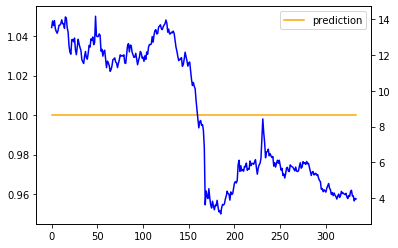

1 to 1 range: 0
---
long: 334 short: 0


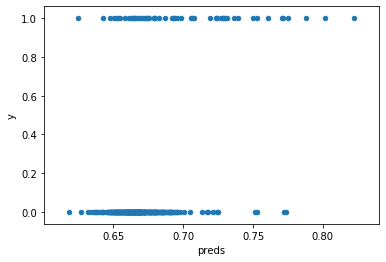

In [22]:
bars_to_plot = 1000
plot_preds(bars_to_plot, predictions_tanh, review_data_raw)

raw_predictions, predictions_tanh = format_predictions_tanh(review_x_data, model, var)
preds_df = pd.DataFrame(pd.Series(raw_predictions.flatten(), name='preds'))
preds_df['y'] = review_y_data
preds_df.plot.scatter('preds','y')
print('---')
print('long:', (preds_df['preds'] > 0.5).sum(), 'short:', (preds_df['preds'] < 0.5).sum())


avg_profit (1 pip fees) -0.22822243156472624
best possible profit (1 pip fees) 0.3188992691423242


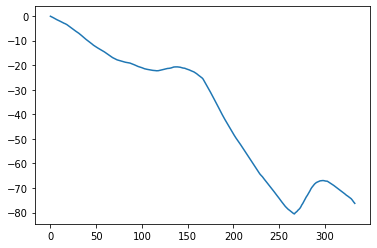

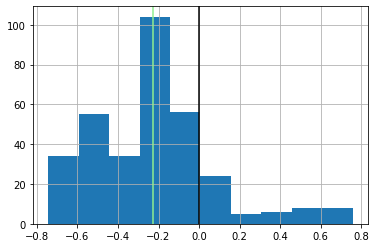

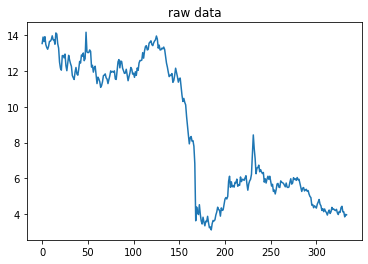

In [23]:
review_data_raw = review_data_raw.flatten()
avg_profit, returns = calc_returns(review_data_raw, predictions_tanh, raw_predictions,
                                   review_y_pct_diff, var, pip_fees=pip_fees)
plot_returns()

plt.plot(review_data_raw)
plt.title('raw data')
plt.show()

In [24]:
#raise Exception('stop at this cell')

### All files

In [30]:
def out_of_sample_results(loaded_files, pip_fees, review_set, model, var):
    all_returns = []
    all_raw = []
    for file_name in list(loaded_files.keys())[:]:
        gc.collect()
        print(file_name)
        var = populate_var_with_dataset(file_name, var)
        if len(var.x) <= 1:
            continue
        (review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions,
         predictions_tanh) = see_predictions(review_set, model, var)
        review_data_raw = review_data_raw.flatten()
        avg_profit, returns = calc_returns(review_data_raw, predictions_tanh, raw_predictions, review_y_pct_diff,
                                           var, pip_fees=pip_fees)
        num_trades = len(returns)
        print('no. trades:', num_trades)
        if var.resample:
            index_data = loaded_files[file_name].resample(var.resample).agg({'Open':'first',
                                                        'High':'max','Low':'min','Close':'last'})
        else:
            index_data = loaded_files[file_name]
            
        if review_set in ['train', 'all']:
            returns.index = index_data[:num_trades].index
        elif review_set == 'test':
            returns.index = index_data[-num_trades:].index
        returns['profit'].name=file_name
        returns['y_pct_diff'].name=file_name
        all_returns.append(returns['profit'])
        all_raw.append(returns['y_pct_diff'])

    return all_returns, all_raw

def drop_outliers(all_returns_final):
    suspect_profits = all_returns_final.max(axis=0).sort_values(ascending=False)
    suspect_high_stocks = list(suspect_profits[suspect_profits > 1].index) # larger than 100% gain on any trade
    print('suspect high stock trade:', suspect_profits[suspect_profits > 1].round(2).to_dict())
    suspect_losses = all_returns_final.min(axis=0).sort_values(ascending=True)
    suspect_low_stocks = list(suspect_losses[suspect_losses < -0.5].index) # larger than -50% loss on any trade
    print('suspect low stock trades:', suspect_losses[suspect_losses < -0.5].round(2).to_dict())
    suspect_stocks = suspect_high_stocks + suspect_low_stocks
    all_returns_final.drop(suspect_stocks, axis='columns', inplace=True)  
    return all_returns_final, suspect_stocks

In [31]:
pip_fees = 1
review_set = 'test' #'test' 'train' ' all'

all_returns, all_raw = out_of_sample_results(loaded_files, pip_fees, review_set, model, var)

MRO
avg_profit (1 pip fees) -0.22822243156472624
best possible profit (1 pip fees) 0.3188992691423242
no. trades: 334
FFIV
avg_profit (1 pip fees) -0.029297752820144966
best possible profit (1 pip fees) 0.11325256078819791
no. trades: 334
AKAM
avg_profit (1 pip fees) 0.11969185386795904
best possible profit (1 pip fees) 0.1262847805037628
no. trades: 334
WRK
avg_profit (1 pip fees) -0.020038630028878738
best possible profit (1 pip fees) 0.18507353681312727
no. trades: 334
AVB
avg_profit (1 pip fees) -0.06617487475861807
best possible profit (1 pip fees) 0.119124272593592
no. trades: 334
F
avg_profit (1 pip fees) 0.05585185442391978
best possible profit (1 pip fees) 0.22186391156856755
no. trades: 334
A
avg_profit (1 pip fees) 0.08745179634318342
best possible profit (1 pip fees) 0.14093570589271467
no. trades: 334
UPS
avg_profit (1 pip fees) 0.13350186546435155
best possible profit (1 pip fees) 0.2406174743695952
no. trades: 334
GS
avg_profit (1 pip fees) 0.021167083097958492
best poss

no. trades: 334
LRCX
avg_profit (1 pip fees) 0.22053906604667323
best possible profit (1 pip fees) 0.2552490963471438
no. trades: 334
FRT
avg_profit (1 pip fees) -0.12318426524977959
best possible profit (1 pip fees) 0.15416922322015275
no. trades: 334
REG
avg_profit (1 pip fees) -0.1186052354350718
best possible profit (1 pip fees) 0.1472431397754964
no. trades: 334
IP
avg_profit (1 pip fees) -0.03073096184858339
best possible profit (1 pip fees) 0.15841448260065874
no. trades: 334
PEP
avg_profit (1 pip fees) 0.02858342051908416
best possible profit (1 pip fees) 0.06391627337681803
no. trades: 334
FRC
avg_profit (1 pip fees) 0.04682842710432269
best possible profit (1 pip fees) 0.14297627733276927
no. trades: 334
RE
avg_profit (1 pip fees) -0.01197944002784419
best possible profit (1 pip fees) 0.1505575711439755
no. trades: 334
MCO
avg_profit (1 pip fees) 0.14099178433682458
best possible profit (1 pip fees) 0.15188737429606486
no. trades: 334
IBM
avg_profit (1 pip fees) -0.0307559510

best possible profit (1 pip fees) 0.1399196671090891
no. trades: 334
APH
avg_profit (1 pip fees) 0.04853160291638293
best possible profit (1 pip fees) 0.15929437868357837
no. trades: 334
PBCT
avg_profit (1 pip fees) -0.10938907345221913
best possible profit (1 pip fees) 0.13701726546058182
no. trades: 334
AMZN
avg_profit (1 pip fees) 0.19611645683792528
best possible profit (1 pip fees) 0.22874412028194535
no. trades: 334
AWK
avg_profit (1 pip fees) 0.08928874350313414
best possible profit (1 pip fees) 0.10478083734938348
no. trades: 334
DXCM
avg_profit (1 pip fees) 0.4311801160769833
best possible profit (1 pip fees) 0.436304966419067
no. trades: 334
LYV
avg_profit (1 pip fees) -0.02228563230347816
best possible profit (1 pip fees) 0.20765158383147314
no. trades: 334
CMG
avg_profit (1 pip fees) 0.20923883170718824
best possible profit (1 pip fees) 0.24058510731116456
no. trades: 334
BEN
avg_profit (1 pip fees) -0.10855533655764468
best possible profit (1 pip fees) 0.1965676837703677
n

no. trades: 334
SNA
avg_profit (1 pip fees) -0.011269003268990238
best possible profit (1 pip fees) 0.14088550272725056
no. trades: 334
AOS
avg_profit (1 pip fees) 0.018321790496526207
best possible profit (1 pip fees) 0.14261802218718275
no. trades: 334
TSN
avg_profit (1 pip fees) -0.028832768756881295
best possible profit (1 pip fees) 0.1702945590352983
no. trades: 334
PGR
avg_profit (1 pip fees) 0.0563805152741027
best possible profit (1 pip fees) 0.10519617248223176
no. trades: 334
VRSN
avg_profit (1 pip fees) 0.026786971530813632
best possible profit (1 pip fees) 0.08608956696575942
no. trades: 334
XLNX
avg_profit (1 pip fees) -0.022841297708288553
best possible profit (1 pip fees) 0.15845452903671808
no. trades: 334
PVH
avg_profit (1 pip fees) -0.10727058196034704
best possible profit (1 pip fees) 0.335199728618408
no. trades: 334
HSY
avg_profit (1 pip fees) 0.05489628383646232
best possible profit (1 pip fees) 0.12745298706211933
no. trades: 334
NEM
avg_profit (1 pip fees) 0.215

suspect high stock trade: {'ETSY': 2.9, 'HAL': 2.39, 'LB': 2.13, 'GPS': 2.11, 'MGM': 2.03, 'FANG': 1.87, 'WHR': 1.78, 'FCX': 1.71, 'MOS': 1.62, 'RCL': 1.62, 'URI': 1.6, 'APTV': 1.58, 'PHM': 1.57, 'LEN': 1.54, 'VTR': 1.51, 'CMG': 1.5, 'FDX': 1.49, 'DHI': 1.42, 'FBHS': 1.42, 'KMX': 1.4, 'DRI': 1.39, 'CTLT': 1.37, 'LOW': 1.36, 'DVN': 1.34, 'ABMD': 1.33, 'HOLX': 1.32, 'SEE': 1.31, 'NVDA': 1.31, 'LNC': 1.28, 'ALGN': 1.27, 'PYPL': 1.26, 'LKQ': 1.25, 'MPC': 1.24, 'AMD': 1.24, 'DXCM': 1.22, 'HBI': 1.21, 'TSCO': 1.2, 'SWK': 1.2, 'SWKS': 1.18, 'BBY': 1.18, 'DXC': 1.18, 'DFS': 1.16, 'EBAY': 1.14, 'WST': 1.13, 'PH': 1.13, 'MAS': 1.11, 'IDXX': 1.11, 'AAP': 1.06, 'BWA': 1.05, 'CMI': 1.05, 'DD': 1.04, 'CTAS': 1.03, 'LRCX': 1.03, 'CRM': 1.03, 'CDNS': 1.02, 'TER': 1.02}
suspect low stock trades: {'NCLH': -0.85, 'CCL': -0.82, 'FANG': -0.82, 'RCL': -0.8, 'FTI': -0.79, 'OKE': -0.78, 'UAL': -0.78, 'HAL': -0.77, 'VTR': -0.77, 'MPC': -0.75, 'DVN': -0.75, 'MGM': -0.75, 'MRO': -0.74, 'LNC': -0.72, 'BA': -0.72,

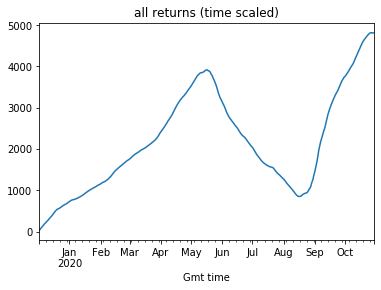

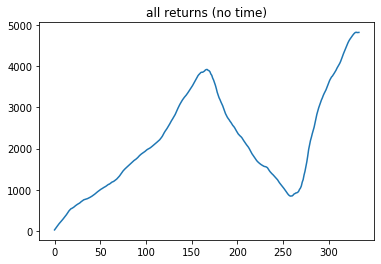

yearly_returns: [ 712.3982696  4100.46188265]


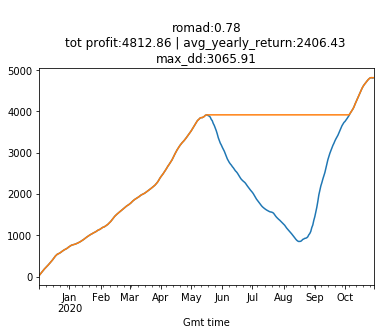

romad_raw: 0.79


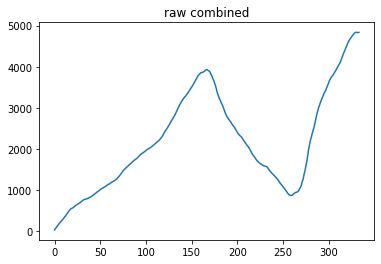

In [75]:
all_returns_final = pd.concat(all_returns, axis=1)
all_returns_final, suspect_stocks = drop_outliers(all_returns_final)

print(f'averge profit (after {pip_fees} pip fees):',np.nanmean(all_returns_final))
all_returns_final['profit'] = all_returns_final.sum(axis=1)
all_returns_final['returns'] = all_returns_final['profit'].cumsum()
all_returns_final['returns'].plot(title='all returns (time scaled)')
plt.show()
all_returns_final['returns'].reset_index(drop=True).plot(title='all returns (no time)')
plt.show()

daily_pct_change = all_returns_final['profit'].resample('1D').sum()
romad = calc_romad(daily_pct_change, filter_large_trades=False, yearly_agg=np.median, plot=True)

all_raw_final = pd.concat(all_raw, axis=1)
all_raw_final.drop(suspect_stocks, axis='columns', inplace=True) 
raw_daily_pct_change = all_raw_final.sum(axis=1).resample('1D').sum()
romad_raw = calc_romad(raw_daily_pct_change, filter_large_trades=False, yearly_agg=np.median, plot=False)
print('romad_raw:', romad_raw)
raw_equity = raw_daily_pct_change.cumsum().reset_index(drop=True)
raw_equity.plot(title='raw combined')
plt.show()

### Performance report

In [33]:
file_name = list(loaded_files.keys())[3]
print(file_name)

var = populate_var_with_dataset(file_name, var)
(review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions,
 predictions_tanh) = see_predictions(review_set, model, var)
review_data_raw = review_data_raw.flatten()

rmse_func = lambda y, y_hat: mean_squared_error(y, y_hat)**0.5
scorer = rmse_func if var.problem_type == 'regression' else accuracy_score

if review_set == 'train':
    y_data = var.y
elif review_set == 'test':
    y_data = var.y_test
elif review_set == 'all':
    y_data = np.concatenate([var.y, var.y_test], axis=0)

if var.problem_type == 'category':
    logit_predictions = predictions_tanh + 1
else:
    logit_predictions = np.where(raw_predictions < 0.5, 0, 1) 

dumb_pred = scorer(y_data, np.zeros(len(y_data)))
print('Dumb:', dumb_pred)
model_score = scorer(y_data, logit_predictions.flatten())
print(f'{metric}:',model_score)
performance = dumb_pred - model_score if var.problem_type == 'regression' else model_score - dumb_pred
print('Performance:', performance)

WRK
Dumb: 0.5089820359281437
accuracy: 0.49101796407185627
Performance: -0.017964071856287456


In [34]:
avg_profit, returns = calc_returns(review_data_raw, predictions_tanh, raw_predictions,
                                   review_y_pct_diff, var, pip_fees=pip_fees)

avg_profit (1 pip fees) -0.020038630028878738
best possible profit (1 pip fees) 0.18507353681312727


In [35]:
num_trades = len(returns)
print('no. trades:', num_trades)

no. trades: 334


In [36]:
win = (returns['profit'] >= 0).sum()
loss = (returns['profit'] < 0).sum()
win_per = win / (win + loss)
print('win percetange',round(win_per,3))

win percetange 0.491


In [37]:
raise Exception('stop at this cell')

Exception: stop at this cell

In [ ]:
def bin_returns(returns):
    returns['pred_bins'] = pd.cut(returns['raw_predictions'], bins=20)
    grouped_returns = returns.groupby('pred_bins')

    fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(15,8))
    grouped_returns.min()['profit'].plot.barh(title='min', ax=ax[0,0])
    grouped_returns.max()['profit'].plot.barh(title='max', ax=ax[0,1])
    grouped_returns.mean()['profit'].plot.barh(title='mean', ax=ax[1,0])
    grouped_returns.sum()['profit'].plot.barh(title='sum', ax=ax[1,1])
    grouped_returns.count()['profit'].plot.barh(title='count', ax=ax[1,2])
    plt.show()
    return grouped_returns


def filter_returns(returns, problem_type, upper_max=1, upper=0.75, lower=0.25, lower_min=0):
    if problem_type == 'binary': 
        filtered_returns = returns.query('((raw_predictions > @upper) & (raw_predictions < @upper_max)) | \
                                          ((raw_predictions > @lower_min) & (raw_predictions < @lower))').copy()
    elif problem_type == 'category': 
        filtered_returns = returns.query('((raw_predictions > @upper) & (raw_predictions < @upper_max)) | \
                                          ((raw_predictions > @lower_min) & (raw_predictions < @lower))').copy()
    else:
        filtered_returns = returns.query('(raw_predictions > @upper) | (raw_predictions < @lower)').copy()

    filtered_returns['returns'] = filtered_returns['profit'].cumsum()
    
    avg_filtered_profit = filtered_returns['profit'].mean()
    print('avg_filtered_profit:',avg_filtered_profit)
    avg_filtered_profit_pips = avg_filtered_profit* 10 ** 4
    print('avg_filtered_profit_pips:', avg_filtered_profit_pips)
    num_samples = len(filtered_returns)
    print('no. trades:',num_samples)
#     add_datetime_index(filtered_returns.copy()) 
#     sharpe = calc_sharpe(filtered_returns['profit'])
#     print('sharpe:', sharpe)
    return filtered_returns, avg_filtered_profit_pips, num_samples

In [ ]:
pip_fees = 1 # each instrument
review_set = 'test' #'test' 'train' 'all'

upper_max = 1 #0.65
upper = 0.6
lower = 0.4
lower_min = 0 #0.393

total_avg_weight_pips = []
for file_name in loaded_files.keys():
    gc.collect()
    print('\n-----',file_name)
    var = populate_var_with_dataset(file_name, var)    
    plt.plot(var.test_data_raw[:,-1])
    plt.title(file_name)
    plt.show()
    (review_data_raw, review_x_data, review_y_data, review_y_pct_diff, raw_predictions,
     predictions_tanh) = see_predictions(review_set, model, var)
    review_data_raw = review_data_raw.flatten()
    avg_profit, returns = calc_returns(review_data_raw, predictions_tanh, raw_predictions, review_y_pct_diff,
                                       var, pip_fees=1)
    returns['returns'].plot(title='returns')
    grouped_returns = bin_returns(returns)
    filtered_returns, avg_pips, samples = filter_returns(returns, var.problem_type, upper_max,
                                                         upper, lower, lower_min)
    if len(filtered_returns) > 0:
        filtered_returns['returns'].plot()
        plt.show()
        
    total_avg_weight_pips.append([samples, avg_pips])
    
total_avg_weight_pips = np.array(total_avg_weight_pips)
tot_avg_pips = ((total_avg_weight_pips[:,0] * total_avg_weight_pips[:,1]).sum() 
                / total_avg_weight_pips[:,0].sum())
print('\n---\n total average pips per filtered trade:', round(tot_avg_pips, 4))